In [8]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

from model import *
from loss import *

sys.path.append(str(Path().resolve().parent))
from task1_utils.batch_preprocess import ctpn_collate_fn, prepare_full_ctpn_targets

import sys
import os

sys.path.insert(0,  os.path.dirname(os.path.dirname(os.getcwd()) ))

from Dataset import SROIEDataset
from torch.utils.data import DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
from tqdm import tqdm


In [44]:
train_dataset = SROIEDataset('train','../../data/train/img','../../data/train/box', target_size=(640, 640))
val_dataset = SROIEDataset('val','../../data/train/img','../../data/train/box', target_size=(640, 640))
test_dataset = SROIEDataset(None, '../../data/test/img','../../data/test/box', target_size=(640, 640))


sub_train_dataset = [train_dataset[i] for i in range(5)]
sub_val_dataset = [val_dataset[i] for i in range(4)]

train_loader = DataLoader(sub_train_dataset, batch_size=5, collate_fn=ctpn_collate_fn,)
val_loader = DataLoader(sub_val_dataset, batch_size=2, collate_fn=ctpn_collate_fn,)


In [29]:
len(train_dataset), len(val_dataset), len(test_dataset)

(563, 63, 347)

In [11]:
CTPN()


CTPN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [12]:

def train_epoch(model, dataloader, criterion, optimizer, device, epoch, num_anchors=10):
    """Одна эпоха обучения для полной CTPN модели"""
    model.train()
    total_loss = 0
    cls_loss_sum = 0
    reg_loss_sum = 0
    side_loss_sum = 0
    
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch}')
    
    for batch_idx, batch in enumerate(progress_bar):
            # Перенос изображений на устройство
            images = batch['images'].to(device)
            
            # Подготовка полных таргетов для CTPN
            gt_data = prepare_full_ctpn_targets(
                batch, 
                num_anchors=num_anchors,
            )
            
            # Forward pass - получаем 3 выхода
            optimizer.zero_grad()
            cls_pred, reg_pred, side_pred = model(images)
            
            # Проверка размеров (для отладки)
            B, C_cls, H_cls, W_cls = cls_pred.shape
   
            cls_target = gt_data['cls_targets']
            reg_target = gt_data['reg_targets']
            side_target = gt_data['side_targets']
            
        
            # Проверяем соответствие размеров
            expected_h = 40  # feature map height
            expected_w = 40  # feature map width
            
            if H_cls != expected_h or W_cls != expected_w:
                print(f"  WARNING: cls_pred имеет размер {H_cls}x{W_cls}, ожидалось {expected_h}x{expected_w}")
                # Делаем ресайз если нужно
                cls_pred = F.interpolate(cls_pred, size=(expected_h, expected_w), mode='bilinear')
                reg_pred = F.interpolate(reg_pred, size=(expected_h, expected_w), mode='bilinear')
                side_pred = F.interpolate(side_pred, size=(expected_h, expected_w), mode='bilinear')
            
            # Вычисление loss
            losses = criterion(cls_pred, reg_pred, side_pred, gt_data)
            
            # Backward pass
            losses['total'].backward()
            
            # Gradient clipping (важно для RNN)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            
            # Optimizer step
            optimizer.step()
            
            # Статистика
            total_loss += losses['total'].item()
            cls_loss_sum += losses['cls'].item()
            reg_loss_sum += losses['reg'].item()
            side_loss_sum += losses['side'].item()
            
            # Обновление progress bar
            progress_bar.set_postfix({
                'loss': losses['total'].item(),
                'cls': losses['cls'].item(),
                'reg': losses['reg'].item(),
                'side': losses['side'].item()
            })
            

    # Вычисляем средние losses за эпоху
    num_batches = max(len(dataloader), 1)
    avg_total_loss = total_loss / num_batches
    avg_cls_loss = cls_loss_sum / num_batches
    avg_reg_loss = reg_loss_sum / num_batches
    avg_side_loss = side_loss_sum / num_batches
    
    return avg_total_loss, avg_cls_loss, avg_reg_loss, avg_side_loss


In [13]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, 
                device, num_epochs=10, num_anchors=10):
    """
    Обучение модели CTPN с сохранением лучшей модели по валидации
    """
    # Перемещаем модель на устройство
    model = model.to(device)
    
    # История обучения
    history = {
        'train_total': [], 'train_cls': [], 'train_reg': [], 'train_side': [],
        'val_total': [], 'val_cls': [], 'val_reg': [], 'val_side': [],
        'best_val_loss': float('inf'),
        'best_epoch': 0
    }
    
    # Общий прогресс-бар для эпох
    epoch_pbar = tqdm(range(num_epochs), desc='Training', unit='epoch')
    
    for epoch in epoch_pbar:
        epoch_num = epoch + 1
        
        # Обучение
        train_losses = train_epoch(
            model, train_loader, criterion, optimizer, 
            device, epoch_num, num_anchors
        )
        avg_total_loss, avg_cls_loss, avg_reg_loss, avg_side_loss = train_losses
        
        # Валидация
        val_losses = validate_epoch(
            model, val_loader, criterion, device, num_anchors
        )
        val_total, val_cls, val_reg, val_side = val_losses
        
        # Сохраняем историю
        history['train_total'].append(avg_total_loss)
        history['train_cls'].append(avg_cls_loss)
        history['train_reg'].append(avg_reg_loss)
        history['train_side'].append(avg_side_loss)
        
        history['val_total'].append(val_total)
        history['val_cls'].append(val_cls)
        history['val_reg'].append(val_reg)
        history['val_side'].append(val_side)
        
        # Сохраняем лучшую модель
        if val_total < history['best_val_loss']:
            history['best_val_loss'] = val_total
            history['best_epoch'] = epoch_num
            
            # Сохраняем модель
            torch.save({
                'epoch': epoch_num,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_total_loss,
                'val_loss': val_total,
                'history': history
            }, 'best_ctpn_model.pth')
        
        # Обновляем описание progress bar
        epoch_pbar.set_postfix({
            'train_loss': f'{avg_total_loss:.4f}',
            'val_loss': f'{val_total:.4f}',
            'best_val': f'{history["best_val_loss"]:.4f}',
            'best_ep': history['best_epoch']
        })

    
    # Визуализация
    visualize_training(history)
    
    print(f"\nОбучение завершено! Лучшая эпоха: {history['best_epoch']} (val_loss: {history['best_val_loss']:.4f})")
    
    return model, history

def train_epoch(model, dataloader, criterion, optimizer, device, epoch, num_anchors=10):
    """Одна эпоха обучения для полной CTPN модели"""
    model.train()
    total_loss = 0
    cls_loss_sum = 0
    reg_loss_sum = 0
    side_loss_sum = 0
    
    # Progress bar для батчей
    batch_pbar = tqdm(dataloader, desc=f'Epoch {epoch} - Training', leave=False)
    
    for batch_idx, batch in enumerate(batch_pbar):
        try:
            images = batch['images'].to(device)
            
            gt_data = prepare_full_ctpn_targets(batch, num_anchors=num_anchors)
            
            optimizer.zero_grad()
            cls_pred, reg_pred, side_pred = model(images)
            
            # Вычисление loss
            losses = criterion(cls_pred, reg_pred, side_pred, gt_data)
            
            # Backward pass
            losses['total'].backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            
            # Optimizer step
            optimizer.step()
            
            # Статистика
            total_loss += losses['total'].item()
            cls_loss_sum += losses['cls'].item()
            reg_loss_sum += losses['reg'].item()
            side_loss_sum += losses['side'].item()
            
            # Обновление progress bar
            batch_pbar.set_postfix({
                'loss': f"{losses['total'].item():.4f}",
                'cls': f"{losses['cls'].item():.4f}",
                'reg': f"{losses['reg'].item():.4f}",
                'side': f"{losses['side'].item():.4f}"
            })
            
        except Exception as e:
            batch_pbar.write(f"Error in batch {batch_idx}: {e}")
            continue
    
    # Средние значения
    num_batches = max(len(dataloader), 1)
    avg_total = total_loss / num_batches
    avg_cls = cls_loss_sum / num_batches
    avg_reg = reg_loss_sum / num_batches
    avg_side = side_loss_sum / num_batches
    
    return avg_total, avg_cls, avg_reg, avg_side

def validate_epoch(model, val_loader, criterion, device, num_anchors=10):
    """Валидационная эпоха"""
    model.eval()
    total_loss = 0
    cls_loss_sum = 0
    reg_loss_sum = 0
    side_loss_sum = 0
    num_batches = 0
    
    # Progress bar для валидации
    val_pbar = tqdm(val_loader, desc='Validation', leave=False)
    
    with torch.no_grad():
        for batch in val_pbar:
            try:
                images = batch['images'].to(device)
                gt_data = prepare_full_ctpn_targets(batch, num_anchors=num_anchors)
                
                cls_pred, reg_pred, side_pred = model(images)
                losses = criterion(cls_pred, reg_pred, side_pred, gt_data)
                
                total_loss += losses['total'].item()
                cls_loss_sum += losses['cls'].item()
                reg_loss_sum += losses['reg'].item()
                side_loss_sum += losses['side'].item()
                num_batches += 1
                
                val_pbar.set_postfix({
                    'loss': f"{losses['total'].item():.4f}",
                    'cls': f"{losses['cls'].item():.4f}"
                })
                
            except Exception as e:
                val_pbar.write(f"Validation error: {e}")
                continue
    
    if num_batches == 0:
        return 0, 0, 0, 0
    
    avg_total = total_loss / num_batches
    avg_cls = cls_loss_sum / num_batches
    avg_reg = reg_loss_sum / num_batches
    avg_side = side_loss_sum / num_batches
    
    return avg_total, avg_cls, avg_reg, avg_side

def visualize_training(history):
    """Визуализация истории обучения"""
    epochs = range(1, len(history['train_total']) + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Total loss
    axes[0, 0].plot(epochs, history['train_total'], 'b-', label='Train')
    axes[0, 0].plot(epochs, history['val_total'], 'r-', label='Val')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Classification loss
    axes[0, 1].plot(epochs, history['train_cls'], 'b-', label='Train')
    axes[0, 1].plot(epochs, history['val_cls'], 'r-', label='Val')
    axes[0, 1].set_title('Classification Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Regression loss
    axes[1, 0].plot(epochs, history['train_reg'], 'b-', label='Train')
    axes[1, 0].plot(epochs, history['val_reg'], 'r-', label='Val')
    axes[1, 0].set_title('Regression Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Side refinement loss
    axes[1, 1].plot(epochs, history['train_side'], 'b-', label='Train')
    axes[1, 1].plot(epochs, history['val_side'], 'r-', label='Val')
    axes[1, 1].set_title('Side Refinement Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ctpn_training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

Training: 100%|██████████| 1/1 [00:23<00:00, 23.40s/epoch, train_loss=0.7088, val_loss=0.6347, best_val=0.6347, best_ep=1]


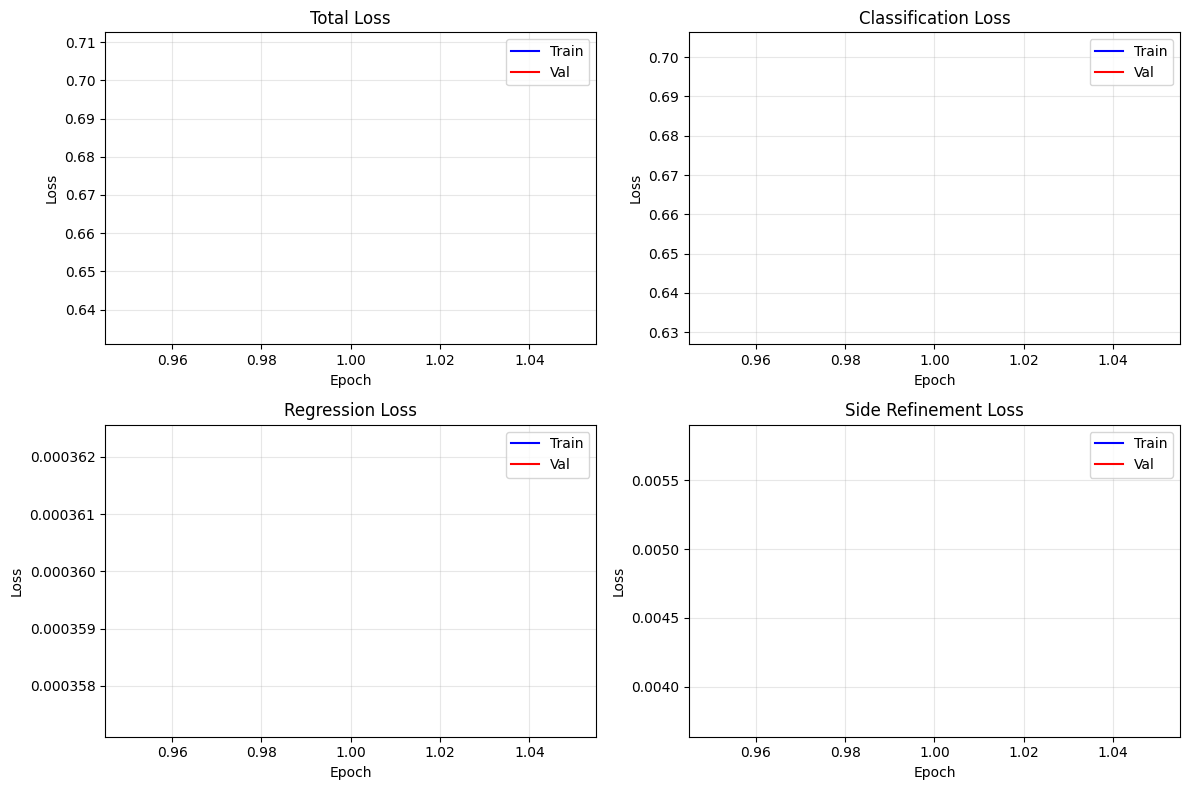


Обучение завершено! Лучшая эпоха: 1 (val_loss: 0.6347)


In [14]:
model = CTPN()
criterion = CTPNLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=1,
        num_anchors=10
    )

In [15]:
history

{'train_total': [0.7088313698768616],
 'train_cls': [0.7026692032814026],
 'train_reg': [0.00036231044214218855],
 'train_side': [0.00579984113574028],
 'val_total': [0.6346765160560608],
 'val_cls': [0.6305797398090363],
 'val_reg': [0.00035735768324229866],
 'val_side': [0.003739388717804104],
 'best_val_loss': 0.6346765160560608,
 'best_epoch': 1}

In [51]:
import cv2
def visualize_text_detections(model, dataloader, device, score_thresh=0.7):
    """Визуализация на оригинальном изображении (без padding)"""
    model.eval()
    batch = next(iter(dataloader))
    
    # Берем оригинальные данные
    image_tensor = batch['images'][0:1].to(device)
    original_size = batch['original_sizes'][0]  # (H, W) оригинала
    scale_factors = batch['scale_factors'][0]  # (scale_w, scale_h)
    
    with torch.no_grad():
        cls_pred, reg_pred, side_pred = model(image_tensor)
    
    # Получаем вероятности
    cls_probs = torch.softmax(cls_pred, dim=1)
    B, C, H_feat, W_feat = cls_probs.shape
    num_anchors = C // 2
    
    # Оригинальное изображение БЕЗ PADDING (нужно загрузить заново)
    img_idx = 0
    img_name = batch['image_ids'][img_idx]
    
    # Загружаем оригинальное изображение без преобразований
    # (вам нужно получить доступ к оригинальному пути)
    # Для примера: используем тензор и удаляем padding
    
    # Берем тензор и конвертируем
    image = batch['images'][img_idx].cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    image = (image * 255).astype(np.uint8)
    
    # УДАЛЯЕМ ЧЁРНЫЙ PADDING
    # Размер после ресайза (до padding)
    target_w, target_h = 800, 600  # из вашего датасета
    scale = scale_factors[0]  # одинаковый для width и height
    
    # Оригинальные размеры до ресайза
    orig_h, orig_w = original_size
    new_w, new_h = int(orig_w * scale), int(orig_h * scale)
    
    # Обрезаем до области с изображением (без черного padding)
    image_cropped = image[:new_h, :new_w, :]
    
    # Масштабируем обратно к оригинальному размеру
    image_final = cv2.resize(image_cropped, (orig_w, orig_h))
    
    # Теперь работаем с image_final (оригинальный размер, без padding)
    image_rgb = cv2.cvtColor(image_final, cv2.COLOR_BGR2RGB)
    gt_img = image_rgb.copy()
    pred_img = image_rgb.copy()
    
    # Anchor высоты (масштабируем обратно)
    anchor_heights = [11, 16, 22, 32, 46, 66, 93, 134, 191, 273]
    stride = 16
    
    # Масштабируем stride и anchors для оригинального размера
    scale_back = 1.0 / scale
    stride_original = stride * scale_back
    anchor_heights_original = [h * scale_back for h in anchor_heights]
    
    # --- 1. Ground Truth (уже в оригинальных координатах) ---
    gt_boxes = batch['boxes'][img_idx]  # Уже масштабированы для padded изображения
    
    # Нужно перемасштабировать GT боксы для оригинального изображения
    for box in gt_boxes:
        x1, y1, x2, y2 = box
        # Масштабируем обратно к оригинальному размеру
        x1 = x1 * scale_back
        y1 = y1 * scale_back
        x2 = x2 * scale_back
        y2 = y2 * scale_back
        
        # Ограничиваем размерами изображения
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(orig_w, x2), min(orig_h, y2)
        
        pts = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=np.int32)
        cv2.polylines(gt_img, [pts], isClosed=True, color=(255, 0, 0), thickness=2)
    
    # --- 2. Предсказания (тоже масштабируем) ---
    cls_probs_reshaped = cls_probs.view(B, H_feat, W_feat, num_anchors, 2)
    positive_scores = cls_probs_reshaped[..., 1]
    max_scores, best_anchors = positive_scores[0].max(dim=-1)
    
    detections_count = 0
    for y in range(H_feat):
        for x in range(W_feat):
            score = max_scores[y, x].item()
            
            if score > score_thresh:
                detections_count += 1
                a_idx = best_anchors[y, x].item()
                
                # Регрессионные значения
                reg_vals = reg_pred[0, a_idx*2:(a_idx+1)*2, y, x].cpu()
                side_vals = side_pred[0, a_idx*2:(a_idx+1)*2, y, x].cpu()
                
                dy = reg_vals[0].item()
                dh = reg_vals[1].item()
                dx_left = side_vals[0].item()
                dx_right = side_vals[1].item()
                
                # Координаты с учетом оригинального масштаба
                cell_center_x = (x + 0.5) * stride_original
                cell_center_y = (y + 0.5) * stride_original
                anchor_h = anchor_heights_original[a_idx]
                
                pred_center_y = cell_center_y + dy * anchor_h
                pred_height = anchor_h * np.exp(dh)
                
                y1 = pred_center_y - pred_height / 2
                y2 = pred_center_y + pred_height / 2
                x1 = cell_center_x + dx_left * stride_original
                x2 = cell_center_x + dx_right * stride_original
                
                # Ограничиваем размерами
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(orig_w, x2), min(orig_h, y2)
                
                if x2 - x1 > 5 and y2 - y1 > 5:  # Фильтр слишком маленьких
                    pts = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=np.int32)
                    cv2.polylines(pred_img, [pts], isClosed=True, 
                                  color=(0, 255, 0), thickness=2)
    
    # Рисуем
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(gt_img)
    axes[0].set_title(f'Ground Truth ({len(gt_boxes)} boxes)')
    axes[0].axis('off')
    
    axes[1].imshow(pred_img)
    axes[1].set_title(f'Predictions ({detections_count} detections, thresh={score_thresh})')
    axes[1].axis('off')
    
    print(f"Image size: {orig_w}x{orig_h}")
    print(f"Detections: {detections_count}")
    
    plt.tight_layout()
    plt.show()
    
    return gt_img, pred_img



Image size: 640x640
Detections: 1600


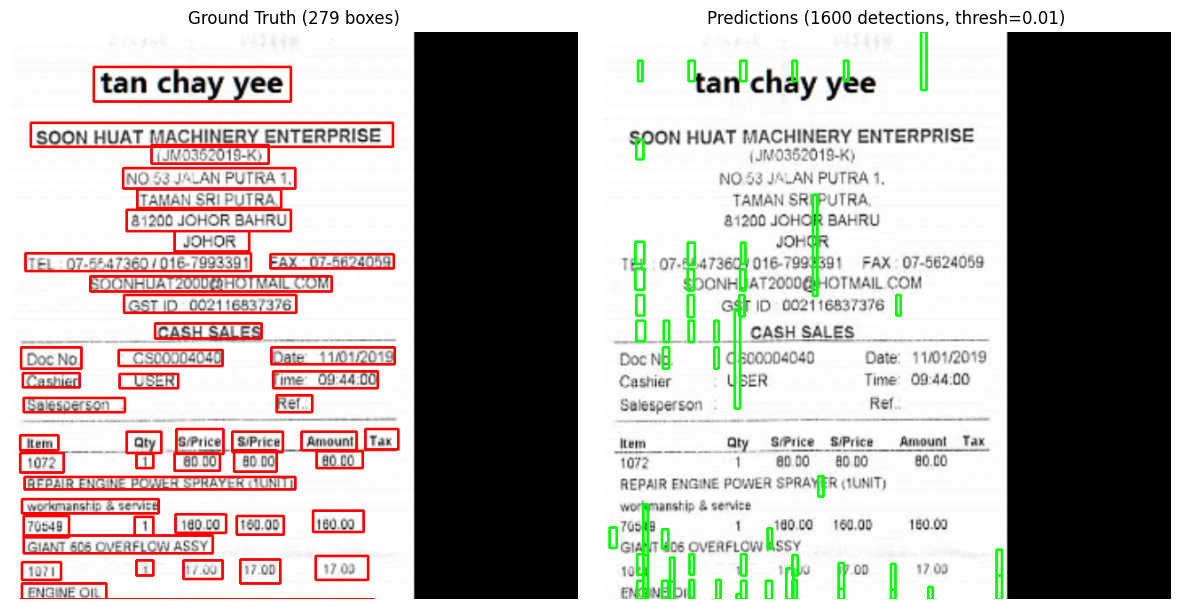

(array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[254, 254, 254],
         [254, 254, 254],
         [255, 255, 255],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[254, 254, 254],
         [254, 254, 254],
         [255, 255, 255],
         ...,
         [  0,   0,   0],
  

In [53]:
visualize_text_detections(model,val_loader,device,0.01)

In [48]:
for b in val_loader:
    print(b.keys())

dict_keys(['images', 'boxes', 'original_quads', 'texts', 'image_ids', 'original_sizes', 'scale_factors'])
dict_keys(['images', 'boxes', 'original_quads', 'texts', 'image_ids', 'original_sizes', 'scale_factors'])


# TODO на завтра:

- скопировать ноутбук и основные зависимости на коллаб (model, loss, data)

- подготовить train / val / test 

- написать функцию, что будет сохранять best_model на активации

- прогнать обучение на 5-10 эпохах

- визуализировать бест модель

- rename DataLoader